In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [3]:
sns.set_style('whitegrid')
pd.options.display.float_format = '{:,.2f}'.format

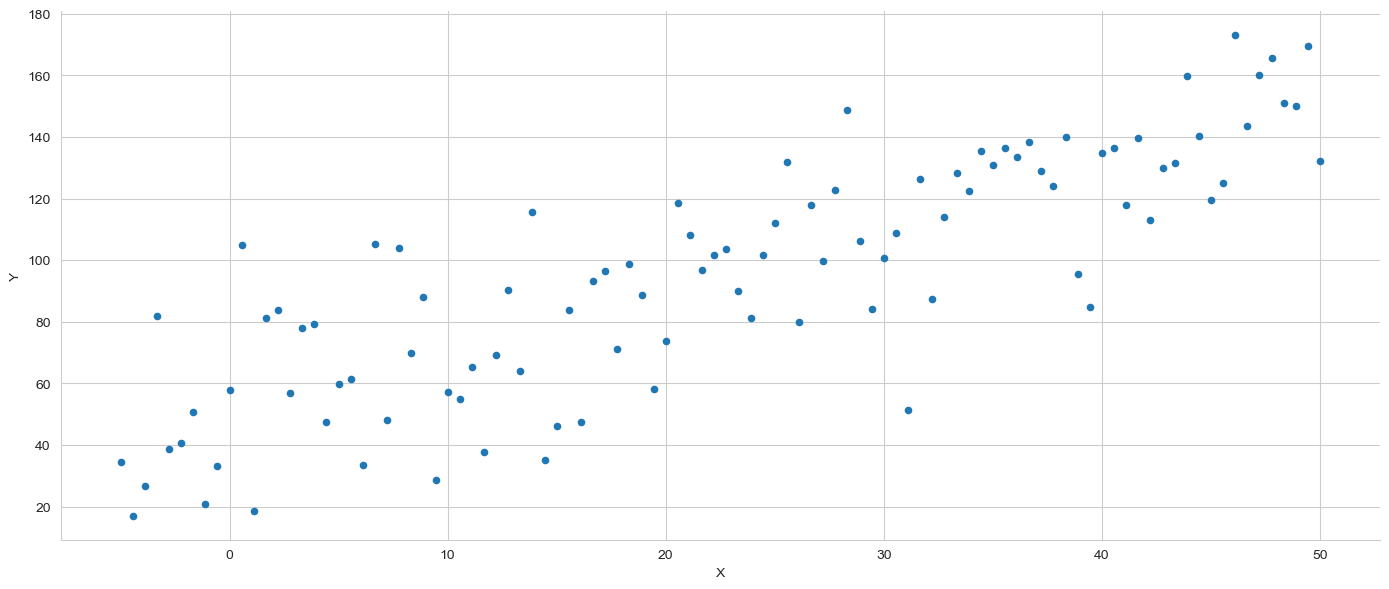

In [8]:
# Simple Regression
# Generate random data
x = np.linspace(-5, 50, 100)
y = 50 + 2 * x + np.random.normal(0, 20, size=len(x))
data = pd.DataFrame({'X': x, 'Y': y})
ax = data.plot.scatter(x='X', y='Y', figsize=(14, 6))
sns.despine()
plt.tight_layout()

In [9]:
X = sm.add_constant(data['X'])
model = sm.OLS(data['Y'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     224.5
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           4.31e-27
Time:                        16:42:57   Log-Likelihood:                -447.91
No. Observations:                 100   AIC:                             899.8
Df Residuals:                      98   BIC:                             905.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.5448      3.713     13.345      0.0

In [10]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
pd.Series(beta, index=X.columns)

const   49.54
X        2.01
dtype: float64

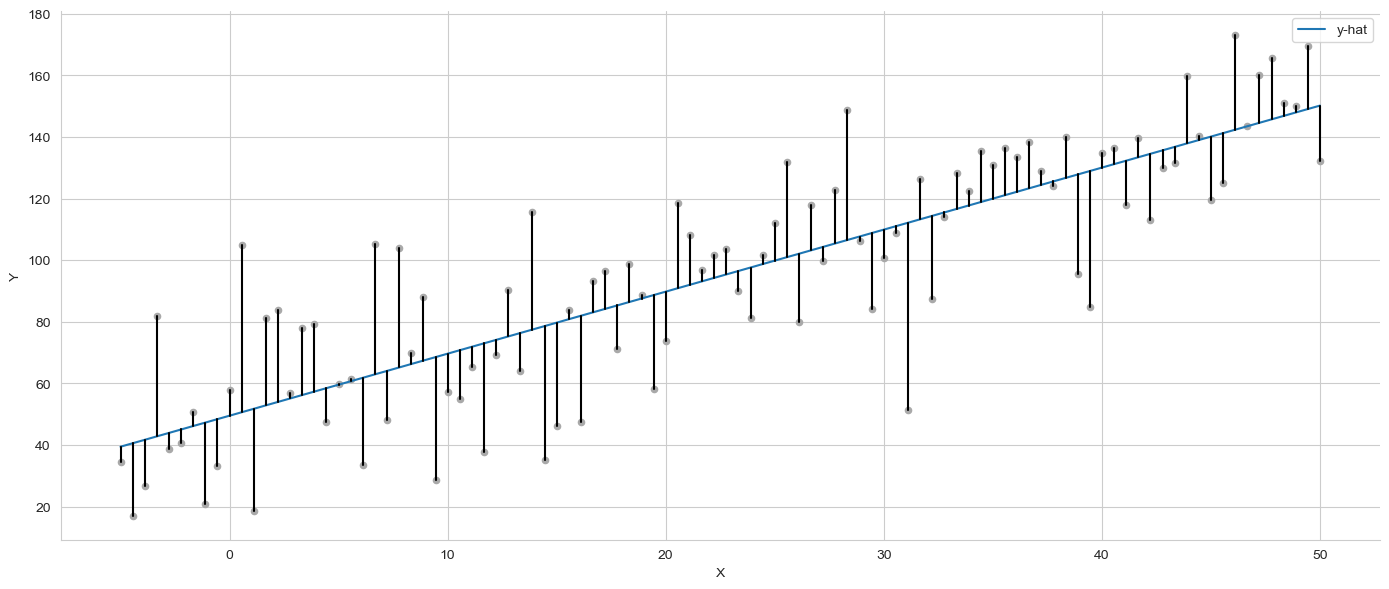

In [11]:
data['y-hat'] = model.predict()
data['residuals'] = model.resid
ax = data.plot.scatter(x='X', y='Y', c='darkgrey', figsize=(14,6))
data.plot.line(x='X', y='y-hat', ax=ax);
for _, row in data.iterrows():
    plt.plot((row.X, row.X), (row.Y, row['y-hat']), 'k-')    
sns.despine()
plt.tight_layout();

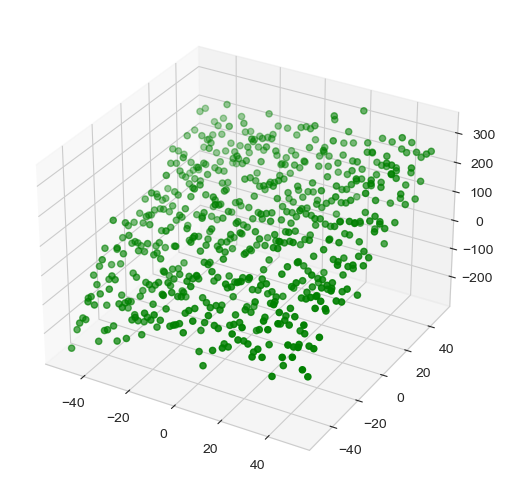

In [13]:
## Generate new random data
## Create data
size = 25
X_1, X_2 = np.meshgrid(np.linspace(-50, 50, size), np.linspace(-50, 50, size), indexing='ij')
data = pd.DataFrame({'X_1': X_1.ravel(), 'X_2': X_2.ravel()})
data['Y'] = 50 + data.X_1 + 3 * data.X_2 + np.random.normal(0, 50, size=size**2)

## Plot
three_dee = plt.figure(figsize=(15, 5)).add_subplot(projection='3d')
three_dee.scatter(data.X_1, data.X_2, data.Y, c='g')
sns.despine()
plt.tight_layout();

In [14]:
X = data[['X_1', 'X_2']]
y = data['Y']

In [15]:
X_ols = sm.add_constant(X)
model = sm.OLS(y, X_ols).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     997.9
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          7.78e-195
Time:                        16:47:34   Log-Likelihood:                -3360.2
No. Observations:                 625   AIC:                             6726.
Df Residuals:                     622   BIC:                             6740.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.0439      2.098     24.333      0.0

In [16]:
beta = np.linalg.inv(X_ols.T.dot(X_ols)).dot(X_ols.T.dot(y))
pd.Series(beta, index=X_ols.columns)

const   51.04
X_1      0.87
X_2      2.99
dtype: float64

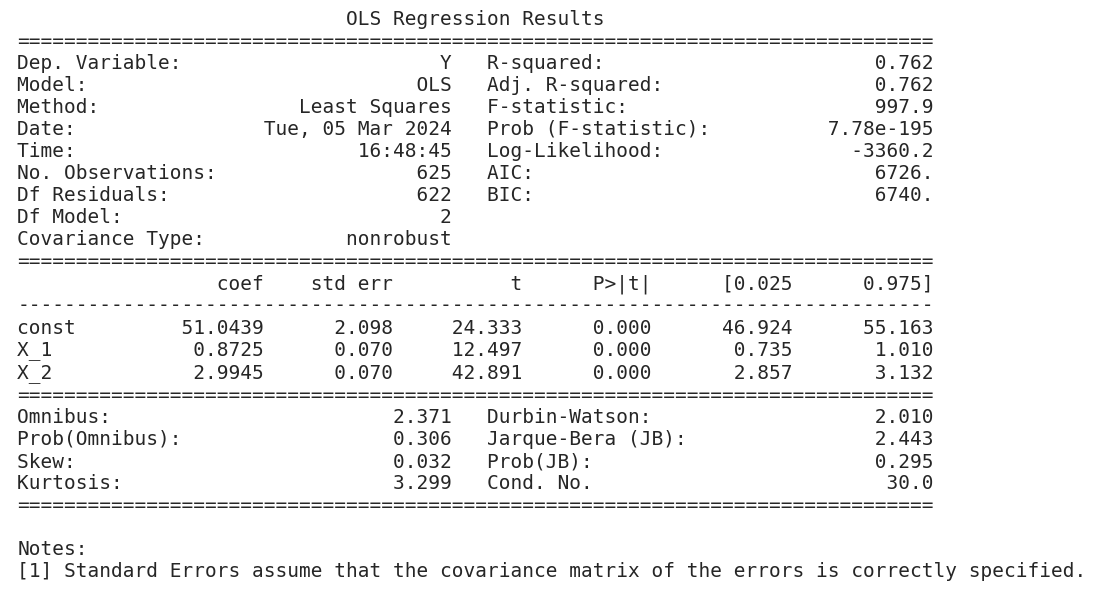

In [18]:
# Save output as an image
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('multiple_regression_summary.png', bbox_inches='tight', dpi=300);

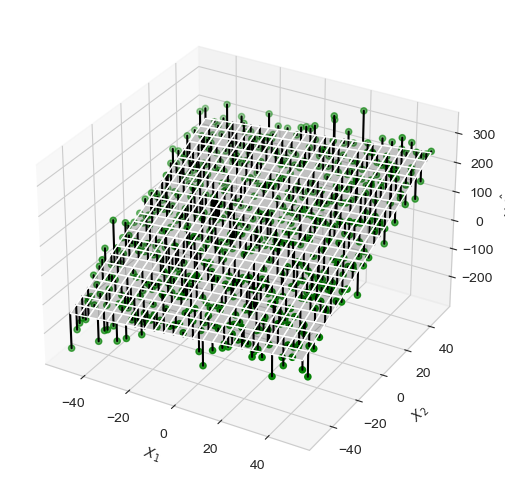

In [19]:
# Display model and residuals
# The following diagram illustrates the hyperplane fitted by the model to the randomly generated data points
three_dee = plt.figure(figsize=(15, 5)).add_subplot(projection='3d')
three_dee.scatter(data.X_1, data.X_2, data.Y, c='g')
data['y-hat'] = model.predict()
to_plot = data.set_index(['X_1', 'X_2']).unstack().loc[:, 'y-hat']
three_dee.plot_surface(X_1, X_2, to_plot.values, color='black', alpha=0.2, linewidth=1, antialiased=True)
for _, row in data.iterrows():
    plt.plot((row.X_1, row.X_1), (row.X_2, row.X_2), (row.Y, row['y-hat']), 'k-');
three_dee.set_xlabel('$X_1$');three_dee.set_ylabel('$X_2$');three_dee.set_zlabel('$Y, \hat{Y}$')
sns.despine()
plt.tight_layout();

In [25]:
# Stochastic Gradient Descent Regression
# Prepare data
scaler = StandardScaler()
X_ = scaler.fit_transform(X)

In [28]:
# Configure SGDRegressor
sgd = SGDRegressor(loss='squared_error', 
                   fit_intercept=True, 
                   shuffle=True, 
                   random_state=42,
                   learning_rate='invscaling', 
                   eta0=0.01, 
                   power_t=0.25)

In [29]:
# Fit model
# sgd.n_iter = np.ceil(10**6 / len(y))
sgd.fit(X=X_, y=y)

SGDRegressor(random_state=42)

In [30]:
coeffs = (sgd.coef_ * scaler.scale_) + scaler.mean_
pd.Series(coeffs, index=X.columns)

X_1     797.20
X_2   2,695.92
dtype: float64

In [32]:
resids = pd.DataFrame({'sgd': y - sgd.predict(X_),
                      'ols': y - model.predict(sm.add_constant(X))})

In [33]:
resids.pow(2).sum().div(len(y)).pow(.5)

sgd   52.32
ols   52.32
dtype: float64

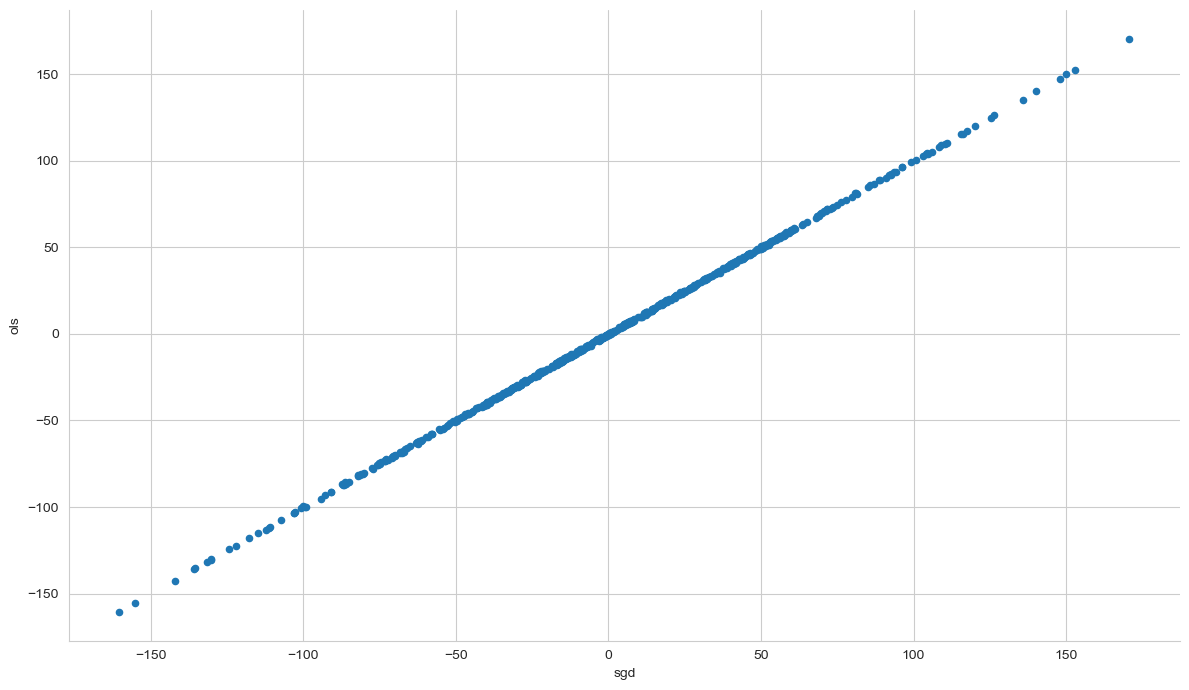

In [34]:
resids.plot.scatter(x='sgd', y='ols')
sns.despine()
plt.tight_layout();